# Credit card fraud detector

## Investigate and process the data

Let's start by downloading and reading in the credit card fraud data set.

In [ ]:
%%bash
wget https://s3-us-west-2.amazonaws.com/sagemaker-e2e-solutions/fraud-detection/creditcardfraud.zip
unzip creditcardfraud.zip

In [2]:
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt

data = pd.read_csv('creditcard.csv', delimiter=',')

Let's take a peek at our data (we only show a subset of the columns in the table):

In [3]:
print(data.columns)
data[['Time', 'V1', 'V2', 'V27', 'V28', 'Amount', 'Class']].describe()
data.head(10)

Index(['Time', 'V1', 'V2', 'V3', 'V4', 'V5', 'V6', 'V7', 'V8', 'V9', 'V10',
       'V11', 'V12', 'V13', 'V14', 'V15', 'V16', 'V17', 'V18', 'V19', 'V20',
       'V21', 'V22', 'V23', 'V24', 'V25', 'V26', 'V27', 'V28', 'Amount',
       'Class'],
      dtype='object')


,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0
5,2.0,-0.425966,0.960523,1.141109,-0.168252,0.420987,-0.029728,0.476201,0.260314,-0.568671,...,-0.208254,-0.559825,-0.026398,-0.371427,-0.232794,0.105915,0.253844,0.081080,3.67,0
6,4.0,1.229658,0.141004,0.045371,1.202613,0.191881,0.272708,-0.005159,0.081213,0.464960,...,-0.167716,-0.270710,-0.154104,-0.780055,0.750137,-0.257237,0.034507,0.005168,4.99,0
7,7.0,-0.644269,1.417964,1.074380,-0.492199,0.948934,0.428118,1.120631,-3.807864,0.615375,...,1.943465,-1.015455,0.057504,-0.649709,-0.415267,-0.051634,-1.206921,-1.085339,40.80,0
8,7.0,-0.894286,0.286157,-0.113192,-0.271526,2.669599,3.721818,0.370145,0.851084,-0.392048,...,-0.073425,-0.268092,-0.204233,1.011592,0.373205,-0.384157,0.011747,0.142404,93.20,0
9,9.0,-0.338262,1.119593,1.044367,-0.222187,0.499361,-0.246761,0.651583,0.069539,-0.736727,...,-0.246914,-0.633753,-0.120794,-0.385050,-0.069733,0.094199,0.246219,0.083076,3.68,0


The class column corresponds to whether or not a transaction is fradulent. We see that the majority of data is non-fraudulant with only $492$ ($.173\%$) of the data corresponding to fraudulant examples.

In [4]:
nonfrauds, frauds = data.groupby('Class').size()
print('Number of frauds: ', frauds)
print('Number of non-frauds: ', nonfrauds)
print('Percentage of fradulent data:', 100.*frauds/(frauds + nonfrauds))

Number of frauds:  492
Number of non-frauds:  284315
Percentage of fradulent data: 0.1727485630620034


This dataset has 28 columns, $V_i$ for $i=1..28$ of anonymized features along with columns for time, amount, and class. We already know that the columns $V_i$ have been normalized to have $0$ mean and unit standard deviation as the result of a PCA. You can read more about PCA here:. 

Tip: For our dataset this amount of preprocessing will give us reasonable accuracy, but it's important to note that there are more preprocessing steps one can use to improve accuracy . For unbalanced data sets like ours where the positive (fraudulent) examples occur much less frequently than the negative (legitimate) examples, we may try “over-sampling” the minority dataset by generating synthetic data (read about SMOTE in Data Mining for Imbalanced Datasets: An Overview (https://link.springer.com/chapter/10.1007%2F0-387-25465-X_40) or undersampling the majority class by using ensemble methods (see http://citeseerx.ist.psu.edu/viewdoc/download?doi=10.1.1.68.6858&rep=rep1&type=pdfor).

In [5]:
feature_columns = data.columns[:-1]
label_column = data.columns[-1]

features = data[feature_columns].values.astype('float32')
labels = (data[label_column].values).astype('float32')

Let's do some analysis and discuss different ways we can preprocess our data. Let's discuss the way in which this data was preprocessed.

## SageMaker XGB

### Prepare Data and Upload to S3

The Amazon common libraries provide utilities to convert NumPy n-dimensional arrays into a the Record-IO format which SageMaker uses for a concise representation of features and labels. The Record-IO format is implemented via protocol buffer so the serialization is very efficient.

In [6]:
model_data = data
model_data.head()
model_data = pd.concat([model_data['Class'], model_data.drop(['Class'], axis=1)], axis=1)
model_data.head()


,Class,Time,V1,V2,V3,V4,V5,V6,V7,V8,...,V20,V21,V22,V23,V24,V25,V26,V27,V28,Amount
0,0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,...,0.251412,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62
1,0,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,...,-0.069083,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69
2,0,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,...,0.524980,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66
3,0,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,...,-0.208038,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50
4,0,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,...,0.408542,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99


In [7]:
import io
import sagemaker.amazon.common as smac

buf = io.BytesIO()
smac.write_numpy_to_dense_tensor(buf, features, labels)
buf.seek(0);

Now we upload the data to S3 using boto3.

In [8]:
import boto3
import os
import sagemaker

session = sagemaker.Session()

bucket = session.default_bucket()
sagemaker_iam_role = sagemaker.get_execution_role()

prefix = 'sagemaker/DEMO-xgboost-fraud'

train_data, validation_data, test_data = np.split(model_data.sample(frac=1, random_state=1729), 
                                                  [int(0.7 * len(model_data)), int(0.9 * len(model_data))])
train_data.to_csv('train.csv', header=False, index=False)
validation_data.to_csv('validation.csv', header=False, index=False)


boto3.Session().resource('s3').Bucket(bucket).Object(os.path.join(prefix, 'train/train.csv')) \
                                .upload_file('train.csv')
boto3.Session().resource('s3').Bucket(bucket).Object(os.path.join(prefix, 'validation/validation.csv')) \
                                .upload_file('validation.csv')
s3_train_data = 's3://{}/{}/train/train.csv'.format(bucket, prefix)
s3_validation_data = 's3://{}/{}/validation/validation.csv'.format(bucket, prefix)
print('Uploaded training data location: {}'.format(s3_train_data))
print('Uploaded training data location: {}'.format(s3_validation_data))

output_location = 's3://{}/{}/output'.format(bucket, prefix)
print('Training artifacts will be uploaded to: {}'.format(output_location))

Uploaded training data location: s3://sagemaker-us-east-1-328296961357/sagemaker/DEMO-xgboost-fraud/train/train.csv
Uploaded training data location: s3://sagemaker-us-east-1-328296961357/sagemaker/DEMO-xgboost-fraud/validation/validation.csv
Training artifacts will be uploaded to: s3://sagemaker-us-east-1-328296961357/sagemaker/DEMO-xgboost-fraud/output


---
## Train

Moving onto training, first we'll need to specify the locations of the XGBoost algorithm containers.
To specify the Linear Learner algorithm, we use a utility function to obtain it's URI. A complete list of build-in algorithms is found here: https://docs.aws.amazon.com/sagemaker/latest/dg/algos.html

In [9]:
from sagemaker.amazon.amazon_estimator import get_image_uri
container = get_image_uri(boto3.Session().region_name, 'xgboost')

	get_image_uri(region, 'xgboost', '0.90-1').


Then, because we're training with the CSV file format, we'll create s3_inputs that our training function can use as a pointer to the files in S3.

In [10]:
s3_input_train = sagemaker.s3_input(s3_data='s3://{}/{}/train'.format(bucket, prefix), content_type='csv')
s3_input_validation = sagemaker.s3_input(s3_data='s3://{}/{}/validation/'.format(bucket, prefix), content_type='csv')

Now, we can specify a few parameters like what type of training instances we'd like to use and how many, as well as our XGBoost hyperparameters.  A few key hyperparameters are:
- `max_depth` controls how deep each tree within the algorithm can be built.  Deeper trees can lead to better fit, but are more computationally expensive and can lead to overfitting.  There is typically some trade-off in model performance that needs to be explored between a large number of shallow trees and a smaller number of deeper trees.
- `subsample` controls sampling of the training data.  This technique can help reduce overfitting, but setting it too low can also starve the model of data.
- `num_round` controls the number of boosting rounds.  This is essentially the subsequent models that are trained using the residuals of previous iterations.  Again, more rounds should produce a better fit on the training data, but can be computationally expensive or lead to overfitting.
- `eta` controls how aggressive each round of boosting is.  Larger values lead to more conservative boosting.
- `gamma` controls how aggressively trees are grown.  Larger values lead to more conservative models.

More detail on XGBoost's hyperparmeters can be found on their GitHub [page](https://github.com/dmlc/xgboost/blob/master/doc/parameter.md).

SageMaker abstracts training with Estimators. We can pass container, and all parameters to the estimator, as well as the hyperparameters for the linear learner and fit the estimator to the data in S3.
Note: For IP protection reasons, SageMaker built-in algorithms, such as XGBoost, can't be run locally, i.e. on the same instance where this Jupyter Notebook code is running. 

In [21]:
xgb = sagemaker.estimator.Estimator(container,
                                    role=sagemaker_iam_role, 
                                    train_instance_count=1, 
                                    train_instance_type='ml.m4.xlarge',
                                    output_path=output_location,
                                    sagemaker_session=session)
xgb.set_hyperparameters(max_depth=5,
                        eta=0.2,
                        gamma=4,
                        min_child_weight=6,
                        subsample=0.8,
                        silent=0,
                        objective='binary:logistic',
                        num_round=100)

In [ ]:
xgb.fit({'train': s3_input_train, 'validation': s3_input_validation}) 

from sagemaker import get_execution_role

linear = sagemaker.estimator.Estimator(container,
                                       role = get_execution_role(), 
                                       train_instance_count=1, 
                                       train_instance_type='ml.c5.4xlarge',
                                       output_path=output_location,
                                       sagemaker_session=session)
linear.set_hyperparameters(feature_dim=features.shape[1],
                           predictor_type='binary_classifier',
                           mini_batch_size=200)

linear.fit({'train': s3_train_data})

### Host XGBoost Model

Now we deploy the estimator to and endpoint.

In [13]:
xgb.name = 'deployed-xgboost-fraud-prediction'
xgb_predictor = xgb.deploy(initial_instance_count = 1, instance_type = 'ml.m4.xlarge')

---------------------------------------------------------------------------------------------------!

### Evaluate

Now that we have a hosted endpoint running, we can make real-time predictions from our model very easily, 
simply by making an http POST request.  But first, we'll need to setup serializers and deserializers for passing our `test_data` NumPy arrays to the model behind the endpoint.

In [14]:
from sagemaker.predictor import csv_serializer 

xgb_predictor.content_type = 'text/csv'
xgb_predictor.serializer = csv_serializer
xgb_predictor.deserializer = None

Now, we'll use a simple function to:
1. Loop over our test dataset
1. Split it into mini-batches of rows 
1. Convert those mini-batchs to CSV string payloads
1. Retrieve mini-batch predictions by invoking the XGBoost endpoint
1. Collect predictions and convert from the CSV output our model provides into a NumPy array

In [15]:
def predict(data, rows=500):
    split_array = np.array_split(data, int(data.shape[0] / float(rows) + 1))
    predictions = ''
    for array in split_array:
        predictions = ','.join([predictions, xgb_predictor.predict(array).decode('utf-8')])

    return np.fromstring(predictions[1:], sep=',')

predictions = predict(test_data.as_matrix()[:, 1:])

/home/ec2-user/anaconda3/envs/mxnet_p36/lib/python3.6/site-packages/ipykernel/__main__.py:9: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.


There are many ways to compare the performance of a machine learning model, but let's start by simply by comparing actual to predicted values. In this case, we're simply predicting whether the customer churned (1) or not (0), which produces a simple confusion matrix.

In [23]:
test_nonfrauds, test_frauds = test_data.groupby('Class').size()
print('Number of frauds: ', test_frauds)
print('Number of non-frauds: ', test_nonfrauds)
print('Percentage of fradulent data:', 100.*test_frauds/(test_frauds + test_nonfrauds))

Number of frauds:  54
Number of non-frauds:  28427
Percentage of fradulent data: 0.1896000842667041


In [17]:
pd.crosstab(index=test_data.iloc[:, 0], columns=np.round(predictions), rownames=['actual'], colnames=['predictions'])

predictions,0.0,1.0
actual,,
0,28426,1
1,14,40


In [26]:
precision = 40/(40+1)
recall = (40)/(40+14)
print(precision)
print(recall)

0.975609756097561
0.7407407407407407


Note, due to randomized elements of the algorithm, you results may differ slightly.

Of the 54 fraudsters, we've correctly predicted 40 of them (true positives). And, we incorrectly predicted 1 case of fraud (false positive). There are also 14 cases of fraud that the model classified as benign transaction (false negatives) - which can get really expensive.

An important point here is that because of the np.round() function above we are using a simple threshold (or cutoff) of 0.5. Our predictions from xgboost come out as continuous values between 0 and 1 and we force them into the binary classes that we began with. So, we should consider adjusting this cutoff. That will almost certainly increase the number of false positives, but it can also be expected to increase the number of true positives and reduce the number of false negatives.

To get a rough intuition here, let's look at the continuous values of our predictions.

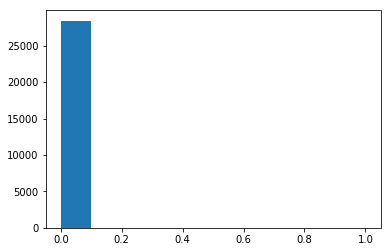

In [18]:
plt.hist(predictions)
plt.show()

By varying the cutoff threshold, we can trade false positives for false negatives. 

In [19]:
pd.crosstab(index=test_data.iloc[:, 0], columns=np.where(predictions > 0.03, 1, 0))

col_0,0,1
Class,,
0,28406,21
1,7,47


In [27]:
precision = 47/(47+21)
recall = (47)/(47+7)
print(precision)
print(recall)

0.6911764705882353
0.8703703703703703


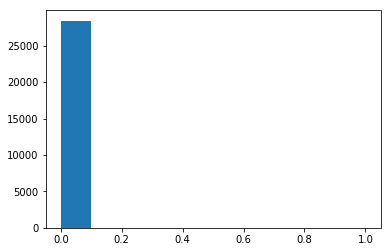

In [28]:
plt.hist(predictions)
plt.show()

## Clean up

We will leave the prediction endpoint running at the end of this notebook so we can handle incoming event streams. However, don't forget to delete the prediction endpoint when you're done. You can do that at the Amazon SageMaker console in the Endpoints page. Or you can run `linear_predictor.delete_endpoint()`


## Data Acknowledgements

The dataset used to demonstrated the fraud detection solution has been collected and analysed during a research collaboration of Worldline and the Machine Learning Group (http://mlg.ulb.ac.be) of ULB (Université Libre de Bruxelles) on big data mining and fraud detection. More details on current and past projects on related topics are available on https://www.researchgate.net/project/Fraud-detection-5 and the page of the [DefeatFraud](https://mlg.ulb.ac.be/wordpress/portfolio_page/defeatfraud-assessment-and-validation-of-deep-feature-engineering-and-learning-solutions-for-fraud-detection/) project
We cite the following works:
* Andrea Dal Pozzolo, Olivier Caelen, Reid A. Johnson and Gianluca Bontempi. Calibrating Probability with Undersampling for Unbalanced Classification. In Symposium on Computational Intelligence and Data Mining (CIDM), IEEE, 2015
* Dal Pozzolo, Andrea; Caelen, Olivier; Le Borgne, Yann-Ael; Waterschoot, Serge; Bontempi, Gianluca. Learned lessons in credit card fraud detection from a practitioner perspective, Expert systems with applications,41,10,4915-4928,2014, Pergamon
* Dal Pozzolo, Andrea; Boracchi, Giacomo; Caelen, Olivier; Alippi, Cesare; Bontempi, Gianluca. Credit card fraud detection: a realistic modeling and a novel learning strategy, IEEE transactions on neural networks and learning systems,29,8,3784-3797,2018,IEEE
* Dal Pozzolo, Andrea Adaptive Machine learning for credit card fraud detection ULB MLG PhD thesis (supervised by G. Bontempi)
* Carcillo, Fabrizio; Dal Pozzolo, Andrea; Le Borgne, Yann-Aël; Caelen, Olivier; Mazzer, Yannis; Bontempi, Gianluca. Scarff: a scalable framework for streaming credit card fraud detection with Spark, Information fusion,41, 182-194,2018,Elsevier
* Carcillo, Fabrizio; Le Borgne, Yann-Aël; Caelen, Olivier; Bontempi, Gianluca. Streaming active learning strategies for real-life credit card fraud detection: assessment and visualization, International Journal of Data Science and Analytics, 5,4,285-300,2018,Springer International Publishing

## Ignore cells below

these are here to gather latency statisitcs on an endpoint. retained them for useful code snippets; to be removed b4 workshop

In [20]:
import time


sagemaker_endpoint_name = 'fraud-detection-endpoint-c5p18xl' 
sagemaker_runtime = boto3.client('sagemaker-runtime')
tic = time.time()
response = sagemaker_runtime.invoke_endpoint(EndpointName=sagemaker_endpoint_name, 
                    ContentType='text/csv', Body=data)
toc = time.time()
print("invocation latency", toc-tic)
print(response)
result = json.loads(response['Body'].read().decode())
print(result)
pred = int(result['predictions'][0]['predicted_label'])
return pred


import json
import os
import boto3
import random
import datetime
import re
import time

def lambda_handler(event, context):
    data_payload = get_data(event, context)
    if not data_payload:
        return
    tic = time.time()
    pred = get_fraud_prediction(data_payload)
    toc = time.time()
    print("prediction + postprocessing latency", toc-tic)
    transformed_data = postprocess_event(event, pred)
    response = store_data_prediction(transformed_data)
    print(response)

def get_data(event, context):
    if random.random() < 0.15:
        return
    non_fraud_example = [1.00000000e+00, -9.66271698e-01, -1.85226008e-01, 1.79299331e+00, -8.63291264e-01, -1.03088794e-02, 1.24720311e+00, 2.37608939e-01,
                         3.77435863e-01, -1.38702404e+00, -5.49519211e-02, -2.26487264e-01, 1.78228229e-01, 5.07756889e-01, -2.87923753e-01, -6.31418109e-01,
                         -1.05964720e+00, -6.84092760e-01, 1.96577501e+00, -1.23262203e+00, -2.08037779e-01, -1.08300455e-01, 5.27359685e-03, -1.90320522e-01,
                         -1.17557538e+00, 6.47376060e-01, -2.21928850e-01, 6.27228469e-02, 6.14576302e-02, 1.23500000e+02]
    fraud_example = [4.0600000e+02, -2.3122265e+00, 1.9519920e+00, -1.6098508e+00, 3.9979055e+00, -5.2218789e-01, -1.4265453e+00, -2.5373874e+00,
                     1.3916572e+00, -2.7700894e+00, -2.7722721e+00, 3.2020333e+00, -2.8999074e+00, -5.9522188e-01, -4.2892537e+00, 3.8972411e-01, -1.1407472e+00,
                     -2.8300557e+00, -1.6822468e-02, 4.1695571e-01, 1.2691055e-01, 5.1723236e-01, -3.5049368e-02, -4.6521106e-01, 3.2019821e-01, 4.4519167e-02,
                     1.7783980e-01, 2.6114500e-01, -1.4327587e-01, 0.0000000e+00]
    examples = [fraud_example, non_fraud_example]
    idx = 1
    if random.random() < 0.05:
        idx = 0
    return ','.join(map(str, examples[idx]))

def get_fraud_prediction(data):
    sagemaker_endpoint_name = 'fraud-detection-endpoint-c5p18xl'
    sagemaker_runtime = boto3.client('sagemaker-runtime')
    tic = time.time()
    response = sagemaker_runtime.invoke_endpoint(EndpointName=sagemaker_endpoint_name, ContentType='text/csv',
                                                 Body=data)
    toc = time.time()
    print("invocation latency", toc-tic)
    print(response)
    result = json.loads(response['Body'].read().decode())
    print(result)
    pred = int(result['predictions'][0]['predicted_label'])
    return predbajk

def postprocess_event(event, pred):
    millisecond_regex = r'\.\d+'
    timestamp = re.sub(millisecond_regex, '', str(datetime.datetime.now()))
    source = random.choice(['Mobile', 'Web', 'Store'])
    return [timestamp, 'random_id', source, str(pred)]

def store_data_prediction(data):
    firehose_delivery_stream = 'fraud-detection-firehose-stream'
    firehose = boto3.client('firehose', region_name=os.environ['AWS_REGION'])
    record = ','.join(data) + '\n'
    response = firehose.put_record(DeliveryStreamName=firehose_delivery_stream, Record={'Data': record})
    return response

sagemaker_endpoint_name = 'fraud-detection-endpoint-c5p18xl'
sagemaker_runtime = boto3.client('sagemaker-runtime')

tic = time.time()
N = 5000
skipped = 0
warmup_flag = 0
for i in range(N):
    data = get_data(None, None)
    if data == None:
        skipped += 1
        continue
    #print(data)    
    response = sagemaker_runtime.invoke_endpoint(EndpointName=sagemaker_endpoint_name, ContentType='text/csv', Body=data)
    warmup_flag += 1
    if warmup_flag == 1:
        print("1st invocation latency", time.time() - tic)
        tic = time.time()
toc = time.time()
N = N - skipped
print("invocation latency", (toc-tic)/N)
print(response)
result = json.loads(response['Body'].read().decode())
print(result)
pred = int(result['predictions'][0]['predicted_label'])


tic = time.time()
skipped = 0
warmup_flag = 0
for i in range(N):
    data = get_data(None, None)
    if data == None:
        skipped += 1
        continue
    warmup_flag += 1
    if warmup_flag == 1:
        print("1st invocation latency", time.time() - tic)
        tic = time.time()
toc = time.time()
N = N - skipped
print("{:10.10f}".format((toc - tic)/N))
#print "{:10.4f}".format(x)
